## Lec 6. 编码器-解码器结构

- Encoder-Decoder
    - VAE `变分自编码器` Variational Auto-Encoder
    - Seq2Seq `序列到序列`
    - Transformer

### 6.1 Model 持久化

- model.state_dict()
- pickle 序列化

In [1]:
import torch.nn as nn
import torch

# 创建一个 Module 并进行训练
model = nn.Linear(10, 20)
model

Linear(in_features=10, out_features=20, bias=True)

In [5]:
model.state_dict()

OrderedDict([('weight',
              tensor([[-0.2214, -0.2236, -0.0530, -0.1180, -0.1116,  0.2902,  0.0420, -0.2459,
                        0.0530,  0.1305],
                      [ 0.2766, -0.0654, -0.1323, -0.1683,  0.1501,  0.1471, -0.0026,  0.2945,
                       -0.1773, -0.0111],
                      [-0.2908,  0.2765, -0.0161, -0.2003,  0.0383, -0.2924,  0.1425, -0.0433,
                       -0.1188, -0.2538],
                      [ 0.2728, -0.0399,  0.2296, -0.1250, -0.0513,  0.2557,  0.1392,  0.0823,
                        0.0929, -0.2434],
                      [ 0.1104, -0.0328, -0.2912,  0.0256, -0.1464,  0.3112,  0.1355, -0.1493,
                       -0.2006, -0.1784],
                      [ 0.2524, -0.1779,  0.2819, -0.0961, -0.0350,  0.1324,  0.1082, -0.1478,
                        0.2104,  0.0309],
                      [-0.0455,  0.1811,  0.1198,  0.1868, -0.1522,  0.2107,  0.2231, -0.1820,
                        0.0389,  0.2449],
                 

In [3]:
# 保存该 Module 的所有参数为二进制数据到本地硬盘
torch.save(model.state_dict(), "model.pt")

In [9]:
# 重新创建一个新的随机参数的同结构的Module实例
model2 = nn.Linear(10, 20)

# 从硬盘中载入之前保存的参数二进制数据，并更新到 model2上
model2.load_state_dict(torch.load("model.pt"))
model2.state_dict()

OrderedDict([('weight',
              tensor([[-0.2214, -0.2236, -0.0530, -0.1180, -0.1116,  0.2902,  0.0420, -0.2459,
                        0.0530,  0.1305],
                      [ 0.2766, -0.0654, -0.1323, -0.1683,  0.1501,  0.1471, -0.0026,  0.2945,
                       -0.1773, -0.0111],
                      [-0.2908,  0.2765, -0.0161, -0.2003,  0.0383, -0.2924,  0.1425, -0.0433,
                       -0.1188, -0.2538],
                      [ 0.2728, -0.0399,  0.2296, -0.1250, -0.0513,  0.2557,  0.1392,  0.0823,
                        0.0929, -0.2434],
                      [ 0.1104, -0.0328, -0.2912,  0.0256, -0.1464,  0.3112,  0.1355, -0.1493,
                       -0.2006, -0.1784],
                      [ 0.2524, -0.1779,  0.2819, -0.0961, -0.0350,  0.1324,  0.1082, -0.1478,
                        0.2104,  0.0309],
                      [-0.0455,  0.1811,  0.1198,  0.1868, -0.1522,  0.2107,  0.2231, -0.1820,
                        0.0389,  0.2449],
                 

In [11]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

In [13]:
with open("model.pkl", "rb") as f:
    model2 = pickle.load(f)

In [15]:
model2.state_dict()

OrderedDict([('weight',
              tensor([[-0.2214, -0.2236, -0.0530, -0.1180, -0.1116,  0.2902,  0.0420, -0.2459,
                        0.0530,  0.1305],
                      [ 0.2766, -0.0654, -0.1323, -0.1683,  0.1501,  0.1471, -0.0026,  0.2945,
                       -0.1773, -0.0111],
                      [-0.2908,  0.2765, -0.0161, -0.2003,  0.0383, -0.2924,  0.1425, -0.0433,
                       -0.1188, -0.2538],
                      [ 0.2728, -0.0399,  0.2296, -0.1250, -0.0513,  0.2557,  0.1392,  0.0823,
                        0.0929, -0.2434],
                      [ 0.1104, -0.0328, -0.2912,  0.0256, -0.1464,  0.3112,  0.1355, -0.1493,
                       -0.2006, -0.1784],
                      [ 0.2524, -0.1779,  0.2819, -0.0961, -0.0350,  0.1324,  0.1082, -0.1478,
                        0.2104,  0.0309],
                      [-0.0455,  0.1811,  0.1198,  0.1868, -0.1522,  0.2107,  0.2231, -0.1820,
                        0.0389,  0.2449],
                 

### 6.2 VAE (Variational Auto-Encoder)

- VAE 使用场景
    - 图像生成, 文本生成, 音频生成....
    - 数据增强
    - ......

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [19]:
28**2

784

In [21]:
class VAE(nn.Module):
    """ 变分自编码器 """
    def __init__(self, input_size=784, hidden_size=256, latent_size=32):
        super().__init__()
        # Encoder 编码器
        self.encoder = nn.Sequential(nn.Linear(input_size, hidden_size), 
                                     nn.ReLU(), 
                                     nn.Linear(hidden_size, hidden_size//2), 
                                     nn.ReLU())
        
        # 计算 Latent Space的均值和对数方差
        self.fc_mu = nn.Linear(hidden_size//2, latent_size)
        self.fc_logvar = nn.Linear(hidden_size//2, latent_size)
        
        # Decoder 解码器
        self.decoder = nn.Sequential(nn.Linear(latent_size, hidden_size//2), 
                                     nn.ReLU(), 
                                     nn.Linear(hidden_size//2, hidden_size), 
                                     nn.ReLU(), 
                                     nn.Linear(hidden_size, input_size), 
                                     nn.Sigmoid())   # 将输出压缩在 (0, 1) 的范围内
        
    def reparameterize(self, mu, logvar):
        """ 重参数化方法 """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        """ 前向传播方法 """
        # Encoding 编码过程
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)

        # Reparameterize 重参数化过程
        z = self.reparameterize(mu, logvar)

        # Decoding 解码过程
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

In [23]:
model = VAE()
x_recon, mu, logvar = model(torch.rand(16, 784))
x_recon.shape, mu.shape, logvar.shape

(torch.Size([16, 784]), torch.Size([16, 32]), torch.Size([16, 32]))

#### 1. 数据集

In [25]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

trans = transforms.Compose([transforms.ToTensor()])

dataset = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

#### 2. 损失函数

In [39]:
def vae_loss(x_recon, x, mu, logvar):
    """ 自定义损失函数, 用于描述重建损失 Loss = 重构损失 + KL散度 """
    # 重构损失
    BCE = F.binary_cross_entropy(x_recon, x.view(-1, 784), reduction="sum")
    
    # KL散度
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

#### 3. 构建模型

In [42]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [44]:
model = VAE().to(device)
loss_func = vae_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#### 4. 训练模型

In [51]:
def train_model(model, dataloader, loss_func, optimizer):
    """ 模型训练函数 """
    model.train()
    total_loss = 0
    for x, _ in dataloader:
        x_recon, mu, logvar = model(x.to(device).view(-1, 784))
        loss = loss_func(x_recon, x.to(device), mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [53]:
n_epoch = 200

train_loss = []
for i in range(n_epoch):
    loss = train_model(model, dataloader, loss_func, optimizer)
    train_loss.append(loss)
    print(f"Epoch {i+1} loss: {round(loss, 4)}")

Epoch 1 loss: 105735.1605
Epoch 2 loss: 84508.9672
Epoch 3 loss: 76878.4308
Epoch 4 loss: 74726.2701
Epoch 5 loss: 72988.5095
Epoch 6 loss: 71488.8895
Epoch 7 loss: 70332.4116
Epoch 8 loss: 69436.2149
Epoch 9 loss: 68742.4215
Epoch 10 loss: 67927.6496
Epoch 11 loss: 67245.9074
Epoch 12 loss: 66662.2193
Epoch 13 loss: 66402.7839
Epoch 14 loss: 65824.9026
Epoch 15 loss: 65461.7239
Epoch 16 loss: 65214.891
Epoch 17 loss: 65021.4579
Epoch 18 loss: 64748.2329
Epoch 19 loss: 64530.0358
Epoch 20 loss: 64335.8569
Epoch 21 loss: 64123.0041
Epoch 22 loss: 63958.0633
Epoch 23 loss: 63756.0304
Epoch 24 loss: 63673.8261
Epoch 25 loss: 63502.3594
Epoch 26 loss: 63342.9389
Epoch 27 loss: 63263.9415
Epoch 28 loss: 63143.5029
Epoch 29 loss: 62981.5405
Epoch 30 loss: 62919.7666
Epoch 31 loss: 62812.5696
Epoch 32 loss: 62738.8578
Epoch 33 loss: 62638.2282
Epoch 34 loss: 62546.3775
Epoch 35 loss: 62514.7489
Epoch 36 loss: 62443.7687
Epoch 37 loss: 62323.3109
Epoch 38 loss: 62261.6365
Epoch 39 loss: 62219.

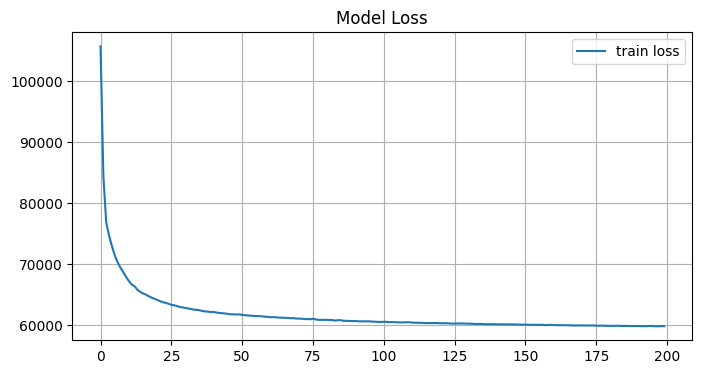

In [57]:
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

plt.figure(figsize=(8, 4))
plt.plot(train_loss, label="train loss")
plt.title("Model Loss")
plt.grid()
plt.legend()
plt.show()

In [73]:
# 使用 VAE 数据增强
with torch.no_grad():
    # 从标准正态分布中采样 Latent 潜层特征
    z = torch.randn(16, 32).to(device) 
    # 通过 VAE-Decoder 将采样得到的 潜层特征 z 生成样本数据 (28x28的图像数据)
    generated_samples = model.decoder(z).view(-1, 1, 28, 28).cpu()
    
generated_samples.shape

torch.Size([16, 1, 28, 28])

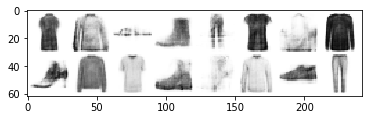

In [74]:
plt.imshow(torchvision.utils.make_grid(generated_samples)[0], cmap="Greys")